# Analyzing Last Interaction Velocity (LIV) Distribution

<div class="alert alert-info">

**Note:**

This notebook demonstrates how to calculate and visualize the last interaction velocity distribution of packets in a TARDIS simulation. You can also have a look at the `LIVPlotter` class in the tardis visualization module in order to see more features related to this.

</div>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from tardis.util.base import (
    atomic_number2element_symbol,
    int_to_roman,
)
from tardis.visualization import plot_util as pu


/home/runner/work/tardis/tardis/tardis/__init__.py:24: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Every simulation run requires [atomic data](io/configuration/components/atomic/atomic_data.rst) and a [configuration file](io/configuration/index.rst). 

## Atomic Data

We recommend using the [kurucz_cd23_chianti_H_He_latest.h5](https://github.com/tardis-sn/tardis-regression-data/raw/main/atom_data/kurucz_cd23_chianti_H_He_latest.h5) dataset.

In [2]:
from tardis.io.atom_data import download_atom_data

# We download the atomic data needed to run the simulation
download_atom_data("kurucz_cd23_chianti_H_He_latest")

Atomic Data kurucz_cd23_chianti_H_He_latest already exists in /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He_latest.h5. Will not download - override with force_download=True.


You can also obtain a copy of the atomic data from the [tardis-regression-data](https://github.com/tardis-sn/tardis-regression-data/tree/main/atom_data) repository.

## Example Configuration File

The configuration file [tardis_example.yml](https://github.com/tardis-sn/tardis/tree/master/docs/tardis_example.yml) is used throughout this Quickstart.

In [3]:
!wget -q -nc https://raw.githubusercontent.com/tardis-sn/tardis/master/docs/tardis_example.yml

In [4]:
!cat tardis_example.yml

# Example YAML configuration for TARDIS
tardis_config_version: v1.0

supernova:
  luminosity_requested: 9.44 log_lsun
  time_explosion: 13 day

atom_data: kurucz_cd23_chianti_H_He_latest.h5

model:
  structure:
    type: specific
    velocity:
      start: 1.1e4 km/s
      stop: 20000 km/s
      num: 20
    density:
      type: branch85_w7

  abundances:
    type: uniform
    O: 0.19
    Mg: 0.03
    Si: 0.52
    S: 0.19
    Ar: 0.04
    Ca: 0.03

plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.5

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000


## Running the Simulation

To run the simulation, import the `run_tardis` function and create the `sim` object.

<div class="alert alert-info">

**Note:**

Get more information about the [progress bars](io/output/progress_bars.rst), [logging configuration](io/optional/tutorial_logging_configuration.ipynb), and [convergence plots](io/visualization/tutorial_convergence_plot.ipynb).

</div>

In [5]:
from tardis import run_tardis

# Run the TARDIS simulation
simulation = run_tardis("tardis_example.yml", log_level="ERROR")

Auto-detected Jupyter notebook environment
Initializing panel with ipywidgets comms for Jupyter notebook


Auto-detected Jupyter notebook environment
Initializing panel with ipywidgets comms for Jupyter notebook


BokehModel(combine_events=True, render_bundle={'docs_json': {'04a426c0-0c2f-4014-8339-2f382b0cf106': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'f609505d-9154-412d-bce5-40d5426566a2': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'72af6338-c279-43ff-bb14-410b7fe7ce84': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

Embedding the final state for Jupyter environments


## HDF

TARDIS can save simulation data to HDF files for later analysis. The code below shows how to load a simulation from an HDF file. This is useful when you want to analyze simulation results without re-running the simulation.

In [6]:
# import astropy.units as u
# import pandas as pd

# hdf_fpath = "add_file_path_here"
# with pd.HDFStore(hdf_fpath, "r") as hdf:
#     sim = u.Quantity(hdf["/simulation"])

## Extracting and Processing Packet Interaction Data


### Core simulation parameters

In [7]:
time_explosion = simulation.plasma.time_explosion
velocity = simulation.simulation_state.velocity
packet_mode="real"

### Packet DataFrame Creation

Creating dataFrames to store packet properties including frequencies, wavelengths, energies and interaction details.

In [8]:
packet_data = pu.extract_and_process_packet_data(simulation, packet_mode)

# Extract individual DataFrames safely
packets_df = packet_data.get("packets_df")
packets_df_line_interaction = packet_data.get("packets_df_line_interaction")


### Species List Generation 
Converting numerical species IDs to element symbols and organizing ions.

In [9]:
# Get unique species IDs from the packets that had line interactions
species_in_model = np.unique(
    packets_df_line_interaction["last_line_interaction_species"].values
)

# Convert species IDs to element symbols by dividing by 100 to get atomic number
# and get the corresponding element symbol
species_list = [
    f"{atomic_number2element_symbol(species // 100)}"
    for species in species_in_model
]


In [10]:
(
    species_mapped_tuples,
    requested_species_ids_tuples,
    keep_colour,
    full_species_list,
) = pu.parse_species_list_util(species_list)

species_flat_list = [
    atomic_num * 100 + ion_num
    for atomic_num, ion_num in requested_species_ids_tuples
]

species_mapped = {
    (k[0] * 100 + k[1]): [v[0] * 100 + v[1] for v in values]
    for k, values in species_mapped_tuples.items()
}

In [11]:
msk = np.isin(species_flat_list, species_in_model)
species = np.array(species_flat_list)[msk]

species_name = []
for species_key, species_ids in species_mapped.items():
    if any(spec_id in species for spec_id in species_ids):
        atomic_number, ion_number = divmod(species_key, 100) #(quotient, remainder) Eg: 1402 = (14, 02)
        if ion_number == 0:
            label = atomic_number2element_symbol(atomic_number)
        else:
            ion_numeral = int_to_roman(ion_number + 1)
            label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
        species_name.append(label)

### Color Mapping
Setting up color schemes for visualizing different atomic species.

In [12]:
# Get a colormap with distinct colors for each species
cmap = plt.get_cmap("jet", len(species_name))

# Initialize list to store colors for each species
color_list = []
species_keys = list(species_mapped.keys())
num_species = len(species_keys)

# Assign colors to each species that appears in the simulation
for species_counter, species_key in enumerate(species_keys):
    # Check if any of the ions of this species are present in the simulation
    if any(species2 in species for species2 in species_mapped[species_key]):
        # Get color from colormap and normalize by number of species
        color = cmap(species_counter / num_species)
        color_list.append(color)


### Data Grouping and Binning
Grouping packets by species and preparing binned data for visualization.

In [13]:
packet_nu_line_range_mask = np.ones(
    packets_df_line_interaction.shape[0],
    dtype=bool,
)

# Group packets by their last line interaction species 
groups = packets_df_line_interaction.loc[packet_nu_line_range_mask].groupby(
    by="last_line_interaction_species"
)

plot_colors = []
plot_data = []
species_not_wvl_range = []
species_counter = 0

# Iterate through each species to collect velocity data
for species_groups in species_mapped.values():
    full_v_last = []
    for specie in species_groups:
        if specie in species:
            # Skip if species has no interactions
            if specie not in groups.groups:
                atomic_number = specie // 100
                ion_number = specie % 100
                ion_numeral = int_to_roman(ion_number + 1)
                label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
                species_not_wvl_range.append(label)
                continue

            # Calculate velocities from radii using v = r/t
            g_df = groups.get_group(specie)
            r_last_interaction = g_df["last_interaction_in_r"].values * u.cm
            v_last_interaction = (r_last_interaction / time_explosion).to(
                "km/s"
            )
            full_v_last.extend(v_last_interaction)

    if full_v_last:
        plot_data.append(full_v_last)
        plot_colors.append(color_list[species_counter])
        species_counter += 1

# Use velocity grid as bin edges for histogram
bin_edges = velocity.to("km/s")

## Visualizing Last Interaction Velocity Distribution



The plots below show the velocity distribution of the last interaction points for different atomic species in the TARDIS simulation. This helps understand where in the ejecta different elements contribute to the observed spectrum.

Each line represents a different element/ion, with:

- The x-axis showing the ***velocity*** in ($\text{km} \, \text{s}^{-1}$) where the last interaction occurred
- The y-axis showing the ***number of packets*** that had their last interaction at that velocity

### Matplotlib


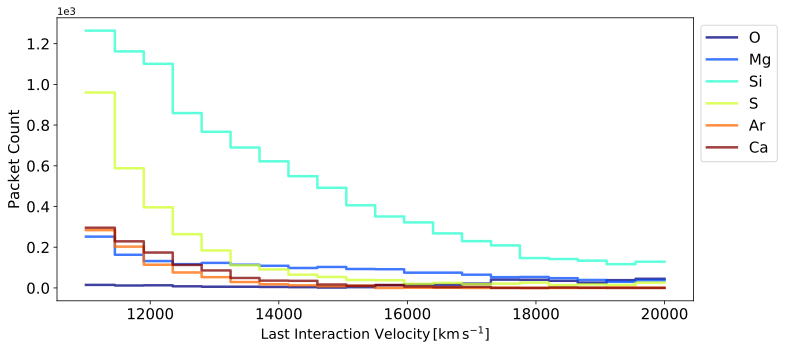

In [14]:
ax = plt.figure(figsize=(11, 5)).add_subplot(111)

for data, color, name in zip(plot_data, plot_colors, species_name):
    # Generate step plot data from histogram data
    hist, _ = np.histogram(data, bins=bin_edges)
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)
    ax.plot(
        step_x,
        step_y,
        label=name,
        color=color,
        linewidth=2.5,
        drawstyle="steps-post",
        alpha=0.75,
    )


# set labels, and legend
xlabel = pu.axis_label_in_latex(
    "Last Interaction Velocity", u.Unit("km/s"), only_text=True
)
ax.ticklabel_format(axis="y", scilimits=(0, 0))
ax.tick_params("both", labelsize=15)
ax.set_xlabel(xlabel, fontsize=14)
ax.set_ylabel(r"$\text{Packet Count}$", fontsize=15)
ax.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0), loc="upper left")
ax.figure.tight_layout()

### Plotly


In [15]:
import plotly.graph_objects as go

# Create plotly figure
fig = go.Figure()

# Loop through each species data and plot histogram
for data, color, name in zip(plot_data, plot_colors, species_name):
    # Generate step plot data from histogram data
    hist, _ = np.histogram(data, bins=bin_edges)
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)

    # Add trace for each species with step-like line plot
    fig.add_trace(
        go.Scatter(
            x=step_x,
            y=step_y,
            mode="lines",
            line=dict(
                color=pu.to_rgb255_string(color),
                width=2.5,
                shape="hv",  # Horizontal-vertical steps
            ),
            name=name,
            opacity=0.75,
        )
    )

xlabel = pu.axis_label_in_latex(
    "Last Interaction Velocity", u.Unit("km/s"), only_text=True
)
fig.update_layout(
    height=600,
    xaxis_title=xlabel,
    font=dict(size=15),
    yaxis={"title": r"$\text{Packet Count}$", "exponentformat": "e", "tickformat":".1e"},
    xaxis=dict(exponentformat="none"),
)
